**Goal of the Code:** Create a figure to show how temperature conditions change under CCT and MSB and how that influences fire activity in the Arctic. The first plot shows under what temperature conditions fires were observed in the Arctic between 2000-2016. The second plot diplays the temperature conditions in the Arctic of RCP4.5 for the last 21 years of the simulation (2080-2100). The final two plots show the difference in temperature conditions of CCT and MSB at the end of the century and RCP4.5. Plotted are the conditions for CCT and MSB, minus the conditions under RCP4.5.


In [1]:
import numpy as np
import iris
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
import matplotlib
import matplotlib.ticker as ticker 
from matplotlib import cm
from matplotlib.colors import ListedColormap

Define a function to calculate the frequency grid of 0.6x0.6 based on T$_{mean}$ and T$_{Xx}$. +8.1 is so that the grid goes from -8.4 to +8.4 and not from 0 to 16.8.

In [2]:
def grid(T_mean, TXx):
    x = int(round(((T_mean) + 8.1) / 0.6))
    y = int(round(((TXx) + 8.1) / 0.6))
    return(x,y)

The first figure will be the current conditions under which fires occur in the Arctic. That dataset has already been created and stored in a txt. It needs to be converted to a grid of 28x28 so it can later be plotted accordingly. 

In [3]:
with open(r"20x20.txt") as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
    
float_list = []

for i in range(0, len(lines)):
    float_list.append(float(lines[i]))

The fire dataset was stored in a 20x20 grid centered around 0, hence why it needs to be converted in the loop to a 28x28 grid. Everything larger than 1000 in fire frequency is assigned the value 1000 to control the colour bar. A list for both the x- and the y-axis is created.

In [4]:
array = np.zeros((28,28)) 
zaehler = -1
for x in range(0, 28):
    for y in range(0, 28):
        if 3 < x <= 23 and 3 < y <= 23:
            zaehler += 1
            if float_list[zaehler] > 1000:
                array[x][y] = 1000
            else:
                array[x][y] = float_list[zaehler]

fire_array = np.where(array == 0, np.nan, array)
fire_x_axes = np.arange(-8.4,8.4, 0.6).tolist()
fire_y_axes = np.arange(-8.4,8.4, 0.6).tolist() 

The second figure displays the temperature conditions of RCP4.5 in 2080-2100. First, the datasets are loaded and a landmask is applied. Land_Type is a dataset that contains a mask over all the plant function types analysed in this figure.

In [5]:
path = r"E:\Datasets_Geoengineering\JS_files_new_sel_var/"
path2 = r"E:\Datasets_Geoengineering\RCP45_variables/"
path3 = r"E:\Datasets_Geoengineering\Lin_Reg_Files/"

landmask = iris.load(path + "TSA_01_sel_var_CCT.all.nc")[0][:,74:,:]

T_mean_RCP_beg = iris.load(path2 + "TSA_RCP45.all.nc")[0][:21*12,74:,:]
T_mean_RCP_beg = T_mean_RCP_beg.data

TXx_RCP_beg = iris.load(path2 + "TREFMXAV_RCP45.all.nc")[0][:21*12,74:,:].data

Land_Type=iris.load(path3 + "Land_Type.nc")[0][:,74:,:]
Land_Type.data.mask = landmask.data.mask


T_mean_RCP = iris.load(path2 + "TSA_RCP45.all.nc")[0][(-21)*12:-1,74:,:]
T_mean_RCP = T_mean_RCP.data

TXx_RCP = iris.load(path2 + "TREFMXAV_RCP45.all.nc")[0][(-21)*12:-1,74:,:].data


Now, the grid array is calculated. This is achieved by looping over all grid cells, excluding those that are over ocean or do not contain the correct plant function type. For each boreal summer month, a 21-year time series is created for RCP4.5 per correct grid cell and the mean of that time series is calculated. This is to calculate the temperature anomalies. The grid function is used to fill the values in the array. For each time step and grid cell, the anomaly is calculated for T$_{mean}$ and T$_{Xx}$ and given to the grid function. The function gives two integer values that indicate, where in the array a +1 has to be added.

In [6]:
array_RCP = np.zeros((100,100)) ## 100x100 in case there are values outside the 28x28 range, those will simply not get plotted later

time = 0
else_sum = 0 ## to count all frequencies outside the 100x100 range to later have the correct divider (this mainly affects anomalies below -8.4 for both Tmean and TXx)

for lat in range(0,22):
        for lon in range(0,144):
            if Land_Type[0,lat,lon].data == 1:
                if landmask.data.mask[0,lat,lon] == False:
                    Jun_Mean = []
                    Jun_Max = []
                    Jul_Mean = []
                    Jul_Max = []
                    Aug_Mean = []
                    Aug_Max = []
                    while time in range(0, 21*12):
                        Jun_Mean.append(T_mean_RCP_beg[time + 5, lat, lon])
                        Jun_Max.append(TXx_RCP_beg[time + 5, lat, lon])
                        Jul_Mean.append(T_mean_RCP_beg[time + 6, lat, lon])
                        Jul_Max.append(TXx_RCP_beg[time + 6, lat, lon])
                        Aug_Mean.append(T_mean_RCP_beg[time + 7, lat, lon])
                        Aug_Max.append(TXx_RCP_beg[time + 7, lat, lon])
                        time = time + 12
                    RCP_Jun_Mean = np.mean(Jun_Mean)
                    RCP_Jun_Max = np.mean(Jun_Max)
                    RCP_Jul_Mean = np.mean(Jul_Mean)
                    RCP_Jul_Max = np.mean(Jul_Max)
                    RCP_Aug_Mean = np.mean(Aug_Mean)
                    RCP_Aug_Max = np.mean(Aug_Max)
                            
                    time = 0
                    
                    while time in range(0, 21*12):
                        x, y = grid(T_mean_RCP[time+5,lat,lon] - RCP_Jun_Mean, TXx_RCP[time+5,lat,lon] - RCP_Jun_Max) ## June
                        if x >= 0: # and y <= 20:
                            array_RCP[y][x] = array_RCP[y][x] + 1
                        else:
                            else_sum += 1
                        x, y = grid(T_mean_RCP[time+6,lat,lon] - RCP_Jul_Mean, TXx_RCP[time+6,lat,lon] - RCP_Jul_Max) ## July
                        if x >= 0: # and y <= 20:
                            array_RCP[y][x] = array_RCP[y][x] + 1
                        else:
                            else_sum += 1
                        x, y = grid(T_mean_RCP[time+7,lat,lon] - RCP_Aug_Mean, TXx_RCP[time+7,lat,lon] - RCP_Aug_Max) ## Aug
                        if x >= 0: # and y <= 20:
                            array_RCP[y][x] = array_RCP[y][x] + 1
                        else:
                            else_sum += 1
                        
                        time = time + 12  
                        
                    time = 0

The sum of the total array is calculated and else_sum is added to calculate the divider, to get the frequencies instead of absolute numbers. The array is multiplied with 100 to get percentage values. 0 values are replaced with NaN values. A grid cell outside the area that will be plotted is used to control the colour bar. The x- and y-axis lists are created. Here, they go from -8.4 to 51.6 to account for the 100x100 grid instead of the 28x28 grid. Everything above 8.4 will not be plotted later, this is just for coding purposes.

In [7]:
sum_array = sum(map(sum, array_RCP)) + else_sum

array_RCP = array_RCP * 100  / sum_array

plot_array_RCP = np.where(array_RCP == 0, np.nan, array_RCP)

plot_array_RCP[28][28] = 3.6 ## to control maximum of colour bar

RCP_x_axes = np.arange(-8.4+0.3,51.6+0.3, 0.6).tolist()
RCP_y_axes = np.arange(-8.4+0.3,51.6+0.3, 0.6).tolist() 

Finally, the figures displaying the difference between CCT and MSB, and RCP4.5 in 2080-2100. First, the datasets are loaded. The frequency plot for RCP4.5 has already been created above, hence only CCT and MSB frequency plots have to be calculated. The datasets are loaded. Only the 21 years around where each ensemble reaches +2°C are opened. There is a -1 in T_mean_CCT_02 since there is a missing month in CCT02 but in the time range before 37 years.

In [8]:
path = r"E:\Datasets_Geoengineering\JS_files_new_sel_var/"

T_mean_CCT_01 = iris.load(path + "TSA_01_sel_var_CCT.all.nc")[0][(-21)*12:-1,74:,:]
T_mean_CCT_02 = iris.load(path + "TSA_02_sel_var_CCT.all.nc")[0][(-21)*12:-1,74:,:]
T_mean_CCT_03 = iris.load(path + "TSA_03_sel_var_CCT.all.nc")[0][(-21)*12:-1,74:,:]

T_mean_CCT_01 = T_mean_CCT_01.data
T_mean_CCT_02 = T_mean_CCT_02.data
T_mean_CCT_03 = T_mean_CCT_03.data

T_mean_MSB_01 = iris.load(path + "TSA_01_sel_var_MSB.all.nc")[0][(-21)*12:-1,74:,:]
T_mean_MSB_02 = iris.load(path + "TSA_02_sel_var_MSB.all.nc")[0][(-21)*12:-1,74:,:]
T_mean_MSB_03 = iris.load(path + "TSA_03_sel_var_MSB.all.nc")[0][(-21)*12:-1,74:,:]

T_mean_MSB_01 = T_mean_MSB_01.data
T_mean_MSB_02 = T_mean_MSB_02.data
T_mean_MSB_03 = T_mean_MSB_03.data

TXx_CCT_01 = iris.load(path + "TREFMXAV_01_sel_var_CCT.all.nc")[0][(-21)*12:-1,74:,:].data
TXx_CCT_02 = iris.load(path + "TREFMXAV_02_sel_var_CCT.all.nc")[0][(-21)*12:-1,74:,:].data
TXx_CCT_03 = iris.load(path + "TREFMXAV_03_sel_var_CCT.all.nc")[0][(-21)*12:-1,74:,:].data

TXx_MSB_01 = iris.load(path + "TREFMXAV_01_sel_var_MSB.all.nc")[0][(-21)*12:-1,74:,:].data
TXx_MSB_02 = iris.load(path + "TREFMXAV_02_sel_var_MSB.all.nc")[0][(-21)*12:-1,74:,:].data
TXx_MSB_03 = iris.load(path + "TREFMXAV_03_sel_var_MSB.all.nc")[0][(-21)*12:-1,74:,:].data

Again, the same procedure as above where the anomalies of CCT and MSB are calculated to the first 21 years of RCP4.5. The mean of the three ensembles is calculated for both CCT and MSB. As MSB has a missing month withing the time span considered here, the code has to be shifted by 1 when that month is reached. As the month is not one of the JJA months, just shifting is enough to account for the missing month. Two seperate grid arrays are filled for CCT and MSB.

In [9]:
array_CCT = np.zeros((100,100))
array_MSB = np.zeros((100,100))

time = 0
else_sum_CCT = 0
else_sum_MSB = 0

for lat in range(0,22):
        for lon in range(0,144):
            if Land_Type[0,lat,lon].data == 1:
                if landmask.data.mask[0,lat,lon] == False: ## only correct grid cells get looped through time
                    JJA_Mean_RCP = []
                    JJA_Max_RCP = []
                    Jun_Mean = []
                    Jun_Max = []
                    Jul_Mean = []
                    Jul_Max = []
                    Aug_Mean = []
                    Aug_Max = []
                    while time in range(0, 21*12):

                        JJA_Mean_RCP.append(T_mean_RCP_beg[time + 5: time + 8, lat, lon])
                        JJA_Max_RCP.append(TXx_RCP_beg[time + 5:time + 8, lat, lon])
                        Jun_Mean.append(T_mean_RCP_beg[time + 5, lat, lon])
                        Jun_Max.append(TXx_RCP_beg[time + 5, lat, lon])
                        Jul_Mean.append(T_mean_RCP_beg[time + 6, lat, lon])
                        Jul_Max.append(TXx_RCP_beg[time + 6, lat, lon])
                        Aug_Mean.append(T_mean_RCP_beg[time + 7, lat, lon])
                        Aug_Max.append(TXx_RCP_beg[time + 7, lat, lon])
                        
                        time = time + 12
       
                    RCP_Jun_Mean = np.mean(Jun_Mean)
                    RCP_Jun_Max = np.mean(Jun_Max)
                    RCP_Jul_Mean = np.mean(Jul_Mean)
                    RCP_Jul_Max = np.mean(Jul_Max)
                    RCP_Aug_Mean = np.mean(Aug_Mean)
                    RCP_Aug_Max = np.mean(Aug_Max)
                            
                    time = 0
                    
                    while time in range(0, 21*12):
                        
                        CCT_T_mean_Jun = (T_mean_CCT_01[time+5,lat,lon] + T_mean_CCT_02[time+5,lat,lon] + T_mean_CCT_03[time+5,lat,lon])/3
                        CCT_T_mean_Jul = (T_mean_CCT_01[time+6,lat,lon] + T_mean_CCT_02[time+6,lat,lon] + T_mean_CCT_03[time+6,lat,lon])/3
                        CCT_T_mean_Aug = (T_mean_CCT_01[time+7,lat,lon] + T_mean_CCT_02[time+7,lat,lon] + T_mean_CCT_03[time+7,lat,lon])/3
                        CCT_TXx_Jun = (TXx_CCT_01[time+5,lat,lon] + TXx_CCT_02[time+5,lat,lon] + TXx_CCT_03[time+5,lat,lon])/3
                        CCT_TXx_Jul = (TXx_CCT_01[time+6,lat,lon] + TXx_CCT_02[time+6,lat,lon] + TXx_CCT_03[time+6,lat,lon])/3
                        CCT_TXx_Aug = (TXx_CCT_01[time+7,lat,lon] + TXx_CCT_02[time+7,lat,lon] + TXx_CCT_03[time+7,lat,lon])/3

                        MSB_T_mean_Jun = (T_mean_MSB_01[time+5,lat,lon] + T_mean_MSB_02[time+5,lat,lon] + T_mean_MSB_03[time+5,lat,lon])/3
                        MSB_T_mean_Jul = (T_mean_MSB_01[time+6,lat,lon] + T_mean_MSB_02[time+6,lat,lon] + T_mean_MSB_03[time+6,lat,lon])/3
                        MSB_T_mean_Aug = (T_mean_MSB_01[time+7,lat,lon] + T_mean_MSB_02[time+7,lat,lon] + T_mean_MSB_03[time+7,lat,lon])/3
                        MSB_TXx_Jun = (TXx_MSB_01[time+5,lat,lon] + TXx_MSB_02[time+5,lat,lon] + TXx_MSB_03[time+5,lat,lon])/3
                        MSB_TXx_Jul = (TXx_MSB_01[time+6,lat,lon] + TXx_MSB_02[time+6,lat,lon] + TXx_MSB_03[time+6,lat,lon])/3
                        MSB_TXx_Aug = (TXx_MSB_01[time+7,lat,lon] + TXx_MSB_02[time+7,lat,lon] + TXx_MSB_03[time+7,lat,lon])/3

                        
                        x, y = grid(CCT_T_mean_Jun - RCP_Jun_Mean, CCT_TXx_Jun - RCP_Jun_Max) ## June
                        if x >= 0 : # and y <= 28:
                            array_CCT[y][x] = array_CCT[y][x] + 1
                        else:
                            else_sum_CCT += 1
                        x, y = grid(CCT_T_mean_Jul - RCP_Jul_Mean, CCT_TXx_Jul - RCP_Jul_Max) ## July
                        if x >= 0 : # and y <= 28:
                            array_CCT[y][x] = array_CCT[y][x] + 1
                        else:
                            else_sum_CCT += 1
                        x, y = grid(CCT_T_mean_Aug - RCP_Aug_Mean, CCT_TXx_Aug - RCP_Aug_Max) ## Aug
                        if x >= 0 : # and y <= 28:
                            array_CCT[y][x] = array_CCT[y][x] + 1
                        else:
                            else_sum_CCT += 1
                        x, y = grid(MSB_T_mean_Jun - RCP_Jun_Mean, MSB_TXx_Jun - RCP_Jun_Max) ## June
                        if x >= 0 : # and y <= 28:
                            array_MSB[y][x] = array_MSB[y][x] + 1
                        else:
                            else_sum_MSB += 1
                        x, y = grid(MSB_T_mean_Jul - RCP_Jul_Mean, MSB_TXx_Jul - RCP_Jul_Max) ## July
                        if x >= 0 : # and y <= 28:
                            array_MSB[y][x] = array_MSB[y][x] + 1
                        else:
                            else_sum_MSB += 1
                        x, y = grid(MSB_T_mean_Aug - RCP_Aug_Mean, MSB_TXx_Aug - RCP_Aug_Max) ## Aug
                        if x >= 0 : # and y <= 28:
                            array_MSB[y][x] = array_MSB[y][x] + 1
                        else:
                            else_sum_MSB += 1
                            
                        time = time + 12                    
                    time = 0

The frequency arrays in % are calculated.

In [10]:
sum_array_CCT = sum(map(sum, array_CCT)) + else_sum_CCT

array_CCT = array_CCT * 100 / sum_array_CCT

sum_array_MSB = sum(map(sum, array_MSB)) + else_sum_MSB

array_MSB = array_MSB * 100 / sum_array_MSB

To calculate the difference to RCP4.5 at the end of the century, the grid array calculated for RCP4.5 above is subtracted from both the CCT and the MSB array. Grids outside the area that will be plotted later are used to control the colour bar. The x- and y-axis lists are created.

In [11]:
subt_array_CCT = np.subtract(array_CCT, array_RCP)

subt_array_CCT = np.where(subt_array_CCT == 0, np.nan, subt_array_CCT)

subt_array_CCT[28][28] = -3.2
subt_array_CCT[28][27] = 4.8

subt_array_MSB = np.subtract(array_MSB, array_RCP)

subt_array_MSB = np.where(subt_array_MSB == 0, np.nan, subt_array_MSB)

subt_array_MSB[28][28] = -3.2
subt_array_MSB[28][27] = 4.8

RFG_x_axes = np.arange(-8.4+0.3,51.6+0.3, 0.6).tolist()
RFG_y_axes = np.arange(-8.4+0.3,51.6+0.3, 0.6).tolist()  

Plotting of the grid arrays.

C:\Users\rhonda\AppData\Local\Temp/ipykernel_19860/1314831499.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax1.plot([-8.4,8.4], [-8.4,8.4], "g--", color = "black")
C:\Users\rhonda\AppData\Local\Temp/ipykernel_19860/1314831499.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax2.plot([-8.4,8.4], [-8.4,8.4], "g--", color = "black")
C:\Users\rhonda\AppData\Local\Temp/ipykernel_19860/1314831499.py:76: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax3.plot([-8.4,8.4], [-8.4,8.4], "g--", color = "black")
C:\Users\rhonda\AppData\Local\Temp/ipykernel_19860/1314831499.py:117: UserWarning: color is redundantly defined by the 'color' keyword argument

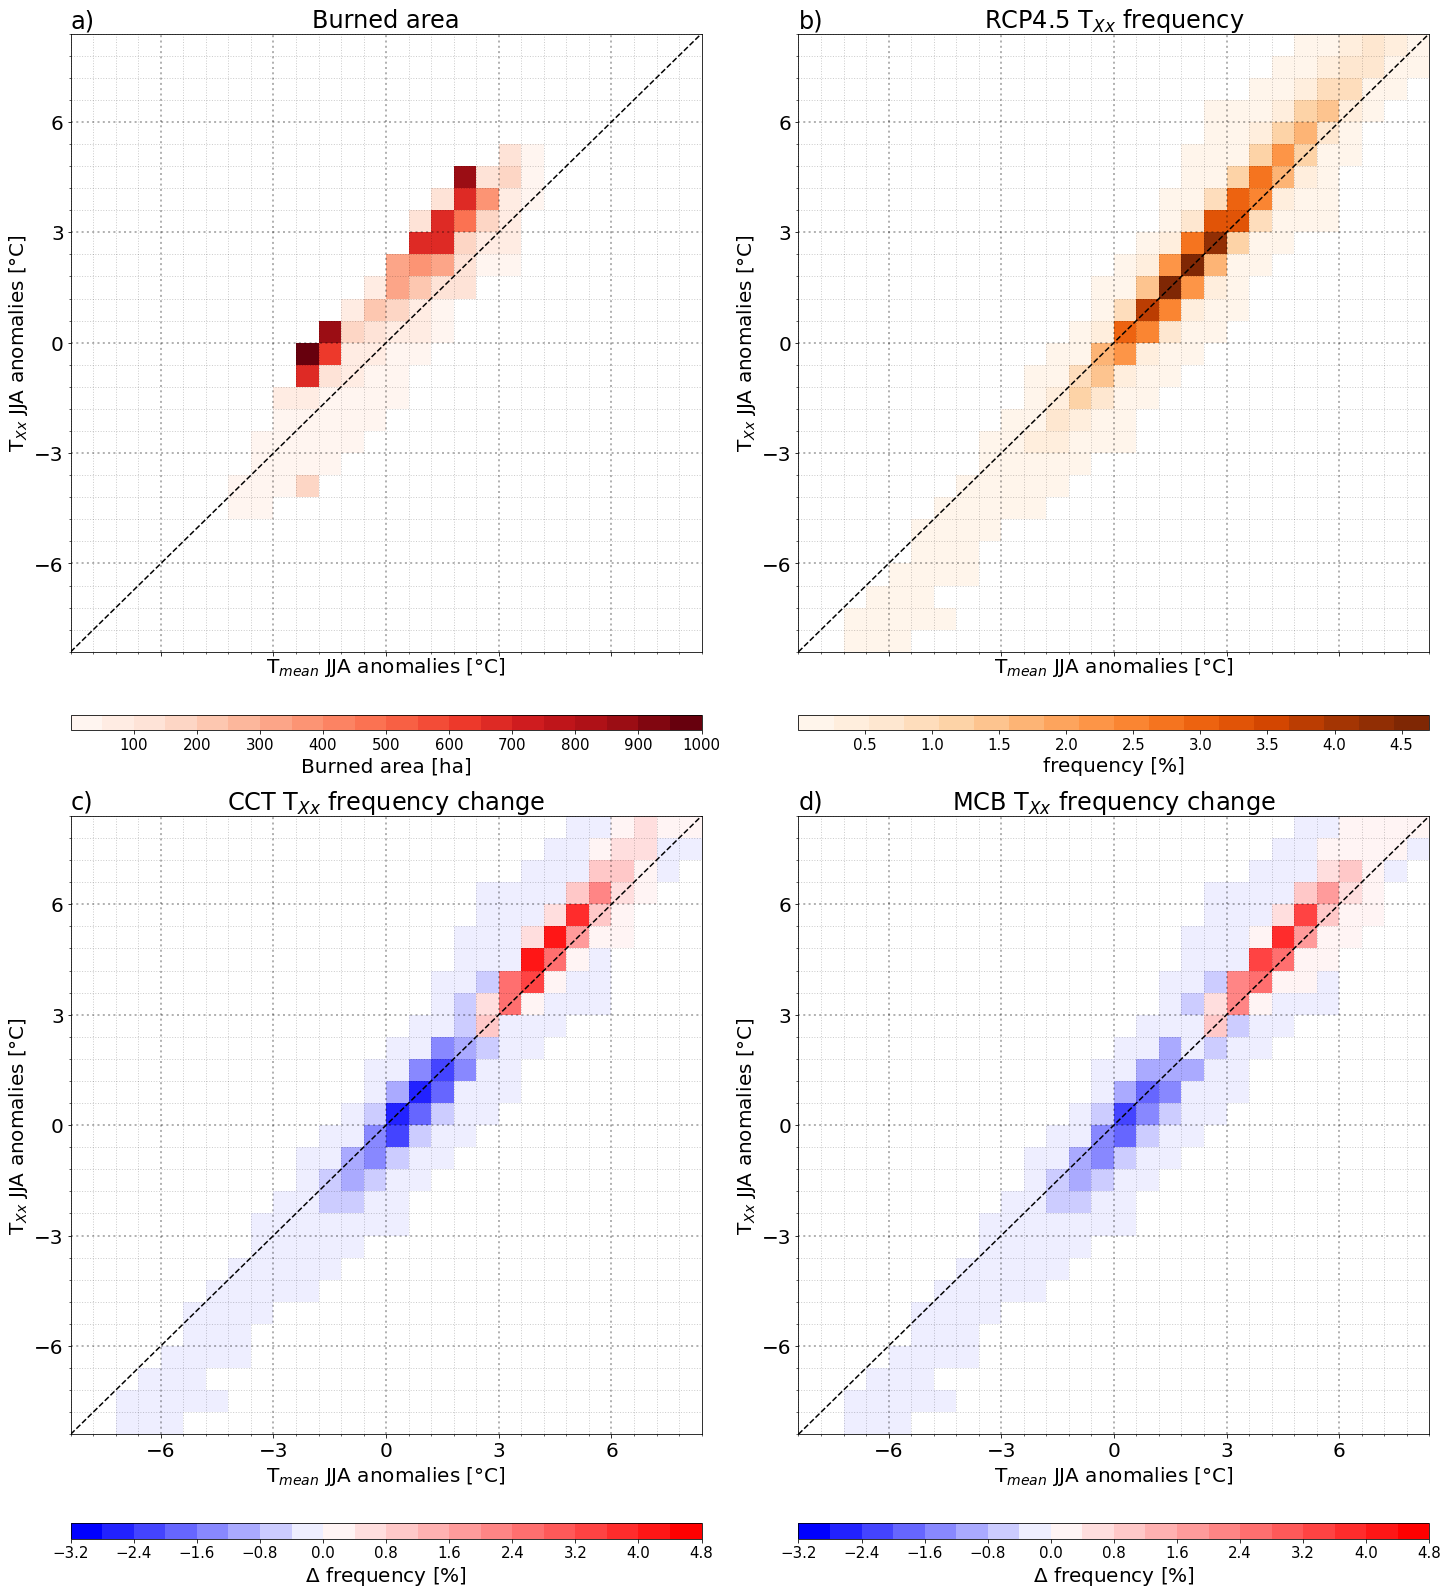

In [12]:
matplotlib.rcParams.update({'font.size': 20})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,  sharex = True, figsize = (20,22), constrained_layout = True)

cmap2 = mpl_cm.get_cmap('Reds', 20) # colourbar colourmap

## Plot a - fire ##

im1 = ax1.pcolormesh(fire_x_axes, fire_y_axes, fire_array, cmap = cmap2)
ax1.plot([-8.4,8.4], [-8.4,8.4], "g--", color = "black")
ax1.set_xlim(-8.4,8.4)
ax1.set_ylim(-8.4,8.4)
ax1.set_xlabel("T$_{mean}$ JJA anomalies [°C]")
ax1.set_ylabel("T$_{Xx}$ JJA anomalies [°C]")
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.6))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.6))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax1.set_title("Burned area")
ax1.set_title("a)", loc = "left")

ax1.grid(axis="x", which = "major", color="black", alpha=.3, linewidth=2, linestyle=":")
ax1.grid(axis="y", which = "major", color="black", alpha=.3, linewidth=2, linestyle=":")
ax1.grid(axis="x", which = "minor", color="black", alpha=.2, linewidth=1, linestyle=":")
ax1.grid(axis="y", which = "minor", color="black", alpha=.2, linewidth=1, linestyle=":")
cb = plt.colorbar(im1, ax = ax1, orientation="horizontal", pad = 0.05, aspect=40)  
cb.set_label("Burned area [ha]")
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
cb.ax.tick_params(labelsize=15) 

## Plot b - RCP8.5 first 20 years ##

cmap3 = mpl_cm.get_cmap('Oranges', 18)

im2 = ax2.pcolormesh(RCP_x_axes, RCP_y_axes, plot_array_RCP, cmap = cmap3)
ax2.plot([-8.4,8.4], [-8.4,8.4], "g--", color = "black")
ax2.set_xlim(-8.4,8.4)
ax2.set_ylim(-8.4,8.4)
ax2.set_xlabel("T$_{mean}$ JJA anomalies [°C]")
ax2.set_ylabel("T$_{Xx}$ JJA anomalies [°C]")
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.6))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.6))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax2.set_title("RCP4.5 T$_{Xx}$ frequency")
ax2.set_title("b)", loc = "left")

ax2.grid(axis="x", which = "major", color="black", alpha=.3, linewidth=2, linestyle=":")
ax2.grid(axis="y", which = "major", color="black", alpha=.3, linewidth=2, linestyle=":")
ax2.grid(axis="x", which = "minor", color="black", alpha=.2, linewidth=1, linestyle=":")
ax2.grid(axis="y", which = "minor", color="black", alpha=.2, linewidth=1, linestyle=":")
cb = plt.colorbar(im2, ax = ax2, orientation="horizontal", pad = 0.05, aspect=40)  
cb.set_label("frequency [%]")
tick_locator = ticker.MaxNLocator(nbins=10)
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.size': 20})
cb.locator = tick_locator
cb.update_ticks()
cb.ax.tick_params(labelsize=15) 

## Plot c - CCT  ##

viridis_30 = cm.get_cmap('bwr', 16) ## Create custom colourmap
viridis_20 = cm.get_cmap("bwr", 20)
viridis_10 = cm.get_cmap("bwr", 24)
newcolors_30 = viridis_30(np.linspace(0, 1, 16))
newcolors_20 = viridis_20(np.linspace(0, 1, 20))
newcolors_10 = viridis_10(np.linspace(0, 1, 24))
newcolors_20[:8, :] = (newcolors_30[:8, :])
newcolors_20[8:, :] = (newcolors_10[12:,:])
newcmp = ListedColormap(newcolors_20)
cmap = newcmp

im3 = ax3.pcolormesh(RFG_x_axes, RFG_y_axes, subt_array_CCT, cmap = cmap)
ax3.plot([-8.4,8.4], [-8.4,8.4], "g--", color = "black")
ax3.set_xlim(-8.4,8.4)
ax3.set_ylim(-8.4,8.4)
ax3.set_xlabel("T$_{mean}$ JJA anomalies [°C]")
ax3.set_ylabel("T$_{Xx}$ JJA anomalies [°C]")
ax3.xaxis.set_minor_locator(ticker.MultipleLocator(0.6))
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(0.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax3.set_title("CCT T$_{Xx}$ frequency change")
ax3.set_title("c)", loc = "left")

ax3.grid(axis="x", which = "major", color="black", alpha=.3, linewidth=2, linestyle=":")
ax3.grid(axis="y", which = "major", color="black", alpha=.3, linewidth=2, linestyle=":")
ax3.grid(axis="x", which = "minor", color="black", alpha=.2, linewidth=1, linestyle=":")
ax3.grid(axis="y", which = "minor", color="black", alpha=.2, linewidth=1, linestyle=":")
cb = plt.colorbar(im3, ax = ax3, orientation="horizontal", pad = 0.05, aspect=40)  
cb.set_label("$\Delta$ frequency [%]")
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.size': 20})
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.ax.tick_params(labelsize=15) 
cb.update_ticks()


## Plot d - MSB  ##


viridis_30 = cm.get_cmap('bwr', 16) ## Create custom colourmap
viridis_20 = cm.get_cmap("bwr", 20)
viridis_10 = cm.get_cmap("bwr", 24)
newcolors_30 = viridis_30(np.linspace(0, 1, 16))
newcolors_20 = viridis_20(np.linspace(0, 1, 20))
newcolors_10 = viridis_10(np.linspace(0, 1, 24))
newcolors_20[:8, :] = (newcolors_30[:8, :])
newcolors_20[8:, :] = (newcolors_10[12:,:])
newcmp = ListedColormap(newcolors_20)
cmap = newcmp

im4 = ax4.pcolormesh(RFG_x_axes, RFG_y_axes, subt_array_MSB, cmap = cmap)
ax4.plot([-8.4,8.4], [-8.4,8.4], "g--", color = "black")
ax4.set_xlim(-8.4,8.4)
ax4.set_ylim(-8.4,8.4)
ax4.set_xlabel("T$_{mean}$ JJA anomalies [°C]")
ax4.set_ylabel("T$_{Xx}$ JJA anomalies [°C]")
ax4.xaxis.set_minor_locator(ticker.MultipleLocator(0.6))
ax4.yaxis.set_minor_locator(ticker.MultipleLocator(0.6))
ax4.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax4.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax4.set_title("MCB T$_{Xx}$ frequency change")
ax4.set_title("d)", loc = "left")

ax4.grid(axis="x", which = "major", color="black", alpha=.3, linewidth=2, linestyle=":")
ax4.grid(axis="y", which = "major", color="black", alpha=.3, linewidth=2, linestyle=":")
ax4.grid(axis="x", which = "minor", color="black", alpha=.2, linewidth=1, linestyle=":")
ax4.grid(axis="y", which = "minor", color="black", alpha=.2, linewidth=1, linestyle=":")
cb = plt.colorbar(im4, ax = ax4, orientation="horizontal", pad = 0.05, aspect=40)  
cb.set_label("$\Delta$ frequency [%]")
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.size': 20})
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.ax.tick_params(labelsize=15) 
cb.update_ticks()

plt.savefig(r"C:\Users\rhonda\OneDrive\Dokumente\Uni-DESKTOP-8400FCB\Master Thesis\Figures for Paper\Figure_4_TSA.jpg",bbox_inches='tight')


Save data as csv file.

In [13]:
import pandas as pd
d = dict(fire_x_axes = fire_x_axes, fire_y_axes = fire_y_axes, RCP_x_axes = RCP_x_axes, RCP_y_axes = RCP_y_axes, RFG_x_axes = RFG_x_axes, RFG_y_axes = RFG_y_axes)
df1 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
# df.to_excel(r'C:\Users\rhonda\OneDrive\Dokumente\Uni-DESKTOP-8400FCB\Master Thesis\Excel_Files\ED_Fig_3.xlsx', index = False)

df2=pd.DataFrame(data=fire_array[0:,0:], index=[i for i in range(fire_array.shape[0])], columns=['f'+str(i) for i in range(fire_array.shape[1])])
df3=pd.DataFrame(data=plot_array_RCP[0:,0:], index=[i for i in range(plot_array_RCP.shape[0])], columns=['f'+str(i) for i in range(plot_array_RCP.shape[1])])
df4=pd.DataFrame(data=subt_array_CCT[0:,0:], index=[i for i in range(subt_array_CCT.shape[0])], columns=['f'+str(i) for i in range(subt_array_CCT.shape[1])])
df5=pd.DataFrame(data=subt_array_MSB[0:,0:], index=[i for i in range(subt_array_MSB.shape[0])], columns=['f'+str(i) for i in range(subt_array_MSB.shape[1])])


In [14]:
from openpyxl import load_workbook

path = r"C:\Users\rhonda\OneDrive\Dokumente\Uni-DESKTOP-8400FCB\Master Thesis\Excel_Files\Source_Data.xlsx"

book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book

df1.to_excel(writer, sheet_name = 'Figure_4_axes')
df2.to_excel(writer, sheet_name = 'Figure_4_a')
df3.to_excel(writer, sheet_name = 'Figure_4_b')
df4.to_excel(writer, sheet_name = 'Figure_4_c')
df5.to_excel(writer, sheet_name = 'Figure_4_d')
writer.close()